In [1]:
SEED = 0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import joblib
from BorutaShap import BorutaShap

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.2
pandas version = 1.2.3


In [2]:
df = pd.read_csv("/home/danssa/proj_ua/data/chasv_development.v1.csv", dtype={'id':np.str})
df2 = df.loc[df['from']!="knhanes"]
df2.describe()

,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,dm,htn
count,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000
mean,0.067598,93.719380,0.428929,47.179829,6.183206,0.020280,1.018628,0.331024,0.234011,0.205590,0.039356,0.757068,0.168417,0.516135,0.025325,0.039046
std,0.251056,22.147902,0.494924,15.570474,0.824044,0.140957,0.007915,0.769946,0.888690,0.669646,0.324305,1.252923,0.560018,1.024153,0.157111,0.193706
min,0.000000,1.704754,0.000000,18.000000,5.000000,0.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,80.803010,0.000000,35.000000,5.500000,0.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,95.813740,0.000000,45.000000,6.000000,0.000000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,110.264000,1.000000,58.000000,7.000000,0.000000,1.025000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,257.176000,1.000000,95.000000,9.000000,1.000000,1.030000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000


In [3]:
#3group age split  

##step 1 finding edge value
abnormal_disc = df2.query('eGFR_ab==1').loc[:,'age']
abnormal_disc = pd.DataFrame(abnormal_disc)

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(abnormal_disc)

ab_disc = est.transform(abnormal_disc).astype('float')
print("edges : ", est.bin_edges_[0])

age0_edge = est.bin_edges_[0][1]
age1_edge = est.bin_edges_[0][2]
age2_edge = est.bin_edges_[0][3]
print('age0_edge:', age0_edge, '\nage1_edge:', age1_edge, '\nage2_edge:', age2_edge)

abnormal_disc['level'] = abnormal_disc.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print('age group:\n',abnormal_disc['level'].value_counts().sort_index())

edges :  [18.         53.80721514 70.94886739 95.        ]
age0_edge: 53.80721513971052 
age1_edge: 70.94886739427912 
age2_edge: 95.0
age group:
 0    2104
1    5505
2    7264
Name: level, dtype: int64


In [4]:
##make 3group by age
df3 = df2.copy()

##age cut set up
df3['level'] = df3.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print(df3['level'].value_counts())

0    147140
1     52377
2     20503
Name: level, dtype: int64


In [5]:
##age0 group
X_age0 = df3[df3['level']==0]
y_age0 = X_age0['eGFR_ab'].astype("int64")

print('\nage0', X_age0['age'].min(), X_age0['age'].max())
print("total cases = %d" %X_age0.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age0), "\nprevalence =", sum(y_age0)/len(y_age0)*100)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_age0, y_age0, test_size=0.2, stratify=y_age0, random_state=SEED)
print("train0 : %d" % sum(y_train0), "test0 : %d" % sum(y_test0))

##age1 group
X_age1 = df3[df3['level']==1]
y_age1 = X_age1['eGFR_ab']

print('\nage1', X_age1['age'].min(), X_age1['age'].max())
print("total cases = %d" %X_age1.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age1), "\nprevalence =", sum(y_age1)/len(y_age1)*100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_age1, y_age1, test_size=0.2, stratify=y_age1, random_state=SEED)
print("train1 : %d" % sum(y_train1), "test1 : %d" % sum(y_test1))

##age2 group
X_age2 = df3[df3['level']==2]
y_age2 = X_age2['eGFR_ab']

print('\nage2', X_age2['age'].min(), X_age2['age'].max())
print("total cases = %d" %X_age2.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age2), "\nprevalence =", sum(y_age2)/len(y_age2)*100)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_age2, y_age2, test_size=0.2, stratify=y_age2, random_state=SEED)
print("train2 : %d" % sum(y_train2), "test2 : %d" % sum(y_test2))


age0 18 53
total cases = 147140
total abnormal function of kidney = 2104 
prevalence = 1.4299306782655974
train0 : 1683 test0 : 421

age1 54 70
total cases = 52377
total abnormal function of kidney = 5505 
prevalence = 10.510338507360101
train1 : 4404 test1 : 1101

age2 71 95
total cases = 20503
total abnormal function of kidney = 7264 
prevalence = 35.42896161537336
train2 : 5811 test2 : 1453


In [6]:
##concat both trainset and testset
X_train = pd.concat([X_train0, X_train1, X_train2])
y_train = pd.concat([y_train0, y_train1, y_train2])

X_test = pd.concat([X_test0, X_test1, X_test2])
y_test = pd.concat([y_test0, y_test1, y_test2])

print("total cases = %d" % (X_train.shape[0] + X_test.shape[0]))
print("total abnormal function of kidney = %d" % (sum(y_train) + sum(y_test)), "\nprevalence =", (sum(y_train)+sum(y_test))/(len(y_train)+len(y_test))*100)

total cases = 220020
total abnormal function of kidney = 14873 
prevalence = 6.759840014544133


In [7]:
# for psm 
#X_test.to_csv("~/proj_ua/data/cha_test_psm.csv", index=False)

In [8]:
X_train_features = X_train.loc[:, 'male':'leucocyte']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

176015 train cases, 12 variables
44005 test cases


In [9]:
#standardization

scaler = StandardScaler()
std_cols=['age','he_uph','he_usg']
std_df=X_train_features[std_cols]

X_train_features[std_cols]=scaler.fit_transform(std_df)
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte
count,176015.000000,1.760150e+05,1.760150e+05,176015.000000,1.760150e+05,176015.000000,176015.000000,176015.000000,176015.000000,176015.000000,176015.000000,176015.000000
mean,0.428929,-1.550143e-16,3.927029e-16,0.020441,-3.871159e-14,0.330739,0.234338,0.206806,0.039497,0.754595,0.167832,0.518944
std,0.494925,1.000003e+00,1.000003e+00,0.141505,1.000003e+00,0.768605,0.888302,0.670976,0.324527,1.251737,0.559132,1.026639
min,0.000000,-1.874509e+00,-1.434883e+00,0.000000,-1.720997e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.825045e-01,-8.284780e-01,0.000000,-1.089793e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.401486e-01,-2.220733e-01,0.000000,1.726161e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,6.949140e-01,9.907359e-01,0.000000,8.038207e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,3.071631e+00,3.416354e+00,1.000000,1.435025e+00,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000


In [10]:
#model fit and mean accuracy
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model : chasv_60model.v1
model = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=0.6000000000000001, learning_rate=0.01, max_depth=3, min_child_weight=12, 
                           n_estimators=500, objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.4,
                          nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean AUC: 0.915 (0.003)


In [11]:
# dimensionality reduction using feature importance
df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 12


,imp
leucocyte,0.016424
he_uro,0.017086
he_ubil,0.019113
he_uket,0.020474
he_unitr,0.032783
male,0.044147
he_uglu,0.049076
he_uph,0.055478
he_ubld,0.059826
he_usg,0.059990


In [12]:
# new model 

## new trainset
X_train_features_new = X_train_features.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]

## model: chasv_60model.v1
model_new = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=0.6000000000000001, learning_rate=0.01, max_depth=3, min_child_weight=12, 
                           n_estimators=500, objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.4,
                           nthread=6, random_state=SEED).fit(X_train_features_new, y_train)
scores_new = evaluate_model(X_train_features_new, y_train, model_new)
print('Mean AUC of new model : %.3f (%.3f)' % (mean(scores_new), std(scores_new)))

Mean AUC of new model : 0.914 (0.003)


## internal and external validation, All

### internal bootstrap

In [13]:
#testset proteinuria
X_test_features = X_test.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

In [14]:
# dataframe for bootstrap
y_prob = model_new.predict_proba(X_test_features)[:,1]
X_test_bs = X_test.copy()
X_test_bs['prob'] = y_prob
X_test_bs

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,level,prob
46222,10096123,0,106.45850,0,43,6.0,0,1.020,0,0,0,0,0,0,0.0,cha,0,0,0,0.067330
111648,10934656,0,95.05386,1,38,5.5,0,1.025,1,0,1,0,0,0,0.0,cha,0,0,0,0.068744
173330,11993516,0,124.01120,1,42,7.0,0,1.010,0,0,0,0,0,0,0.0,cha,0,0,0,0.060523
123757,11635543,0,79.67572,0,41,6.0,0,1.020,0,0,0,0,2,0,0.0,cha,0,0,0,0.079890
134654,11564913,0,95.82392,0,35,6.0,0,1.030,0,0,0,0,0,0,0.0,cha,0,0,0,0.030781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278635,2501940,0,87.90581,1,72,6.5,0,1.010,0,0,0,0,0,1,0.0,sv,0,0,2,0.724167
196614,10894008,1,10.00520,0,84,5.0,0,1.010,2,0,0,0,1,0,3.0,cha,0,0,2,0.970549
94180,10724143,1,55.58477,1,83,6.5,1,1.020,0,0,0,0,1,0,2.0,cha,0,0,2,0.873898
114884,11161009,0,88.00092,1,74,5.5,0,1.030,2,0,0,0,0,0,0.0,cha,0,0,2,0.836639


In [15]:
# test set
data = X_test_bs

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box = []
th_box = []
se_box = []
sp_box = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box.append(best_thresh)
    se_box.append(se)
    sp_box.append(sp)

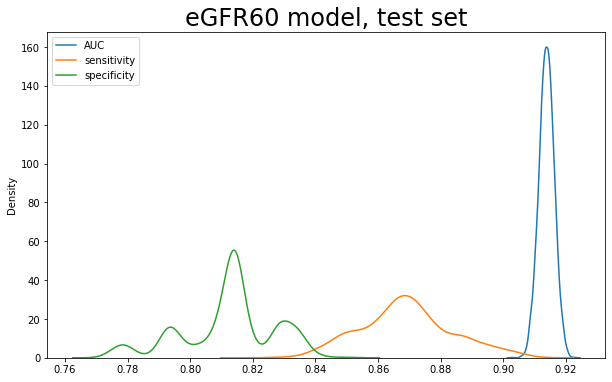

auc mean: 0.91 (0.91-0.92), median:0.91
se  mean: 0.87 (0.84-0.90), median:0.87
sp  mean: 0.81 (0.78-0.84), median:0.81
th  mean: 0.49 (0.41-0.55), median:0.49


In [16]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box, label='AUC') 
sns.kdeplot(se_box, label='sensitivity')
sns.kdeplot(sp_box, label='specificity')
plt.title("eGFR60 model, test set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box), lower_auc, upper_auc, np.median(auc_box)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box), lower_se, upper_se, np.median(se_box)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box), lower_sp, upper_sp, np.median(sp_box)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box), lower_th, upper_th, np.median(th_box)))

### external bootstrap

In [17]:
#external validation in knhanes set

ev_wt = pd.read_csv("/home/danssa/proj_ua/data/knhanes_12y.v1.csv")
ev_wt = ev_wt.query('age>=18&age<80')

ev = df[(df['from']=="knhanes") & (df['age']>=18) & (df['age']<80)]
ev['leucocyte'] = np.nan
ev['eGFR_ab'] = np.where(ev['eGFR_ckd']<60,1,0)
ev['wt'] = np.array(ev_wt['wt_12y'])

y_test_ev = ev['eGFR_ab']
print("\nev cases=%d, p cases=%d, ratio=%.2f" % (ev.shape[0], sum(y_test_ev), sum(y_test_ev)/ev.shape[0]*100))

X_test_features_ev = ev.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features_ev[std_cols]
X_test_features_ev[std_cols]=scaler.transform(std_df)
print(X_test_features_ev.shape)
X_test_features_ev.describe()


ev cases=62945, p cases=1940, ratio=3.08
(62945, 7)


,male,he_usg,he_uph,he_ubld,he_uglu,he_upro,age
count,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000
mean,0.451696,0.049935,-0.526456,0.579458,0.094305,0.117039,0.142261
std,0.497665,0.783960,1.005068,1.027015,0.539820,0.409067,1.030071
min,0.000000,-1.720997,-1.434883,0.000000,0.000000,0.000000,-1.874509
25%,0.000000,-0.458588,-1.434883,0.000000,0.000000,0.000000,-0.654033
50%,0.000000,0.172616,-0.828478,0.000000,0.000000,0.000000,0.181029
75%,1.000000,0.803821,0.384331,1.000000,0.000000,0.000000,0.951856
max,1.000000,1.435025,3.416354,5.000000,5.000000,5.000000,2.043861


In [18]:
# dataframe for bootstrap, external validation set
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
X_test_bs_ev = ev.copy()
X_test_bs_ev['prob'] = y_prob_ev
X_test_bs_ev

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,wt,prob
210862,A901021301,0,76.36104,1,78,5.5,0,1.020,0,0,0,0,0,0,NaN,knhanes,0,0,320.734691,0.858149
210863,A901021302,0,90.97259,0,75,6.0,0,1.025,0,0,0,0,0,0,NaN,knhanes,0,0,456.006780,0.794169
210864,A901022601,0,106.45850,0,43,6.0,0,1.020,0,0,0,0,0,0,NaN,knhanes,0,0,592.556654,0.067330
210865,A901023304,0,85.96295,0,71,6.0,0,1.020,0,4,0,0,0,0,NaN,knhanes,0,0,288.311428,0.745826
210866,A901023502,0,110.41680,0,42,8.5,0,1.020,0,0,0,0,0,0,NaN,knhanes,0,0,592.556654,0.046424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273802,P549819801,0,75.12561,0,74,5.0,0,1.025,0,0,0,0,4,0,NaN,knhanes,0,0,108.891200,0.859016
273803,P549879801,0,71.56396,1,75,5.0,0,1.025,0,0,0,0,2,0,NaN,knhanes,0,0,201.759400,0.862930
273804,P549879802,0,66.76084,0,74,5.0,0,1.015,0,0,0,0,1,0,NaN,knhanes,0,0,163.336800,0.881608
273805,P549980702,0,90.97181,0,34,5.0,0,1.030,0,0,0,0,1,0,NaN,knhanes,0,0,232.329500,0.080707


In [19]:
# load dataset
data = X_test_bs_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_ev = []
th_box_ev = []
se_box_ev = []
sp_box_ev = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
    
    auc_box_ev.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_ev.append(best_thresh)
    se_box_ev.append(se)
    sp_box_ev.append(sp)

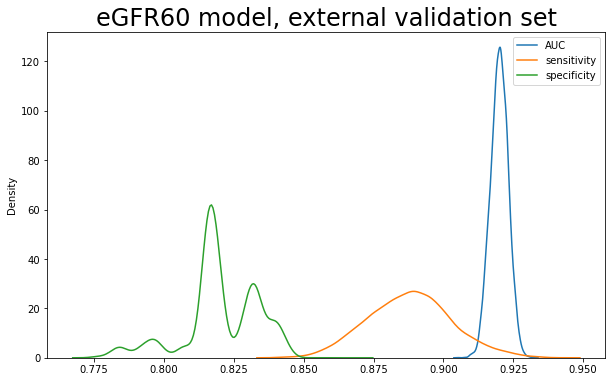

auc mean: 0.92 (0.91-0.93), median:0.92
se  mean: 0.89 (0.86-0.92), median:0.89
sp  mean: 0.82 (0.79-0.84), median:0.82
th  mean: 0.48 (0.41-0.53), median:0.47


In [20]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_ev, label='AUC') 
sns.kdeplot(se_box_ev, label='sensitivity')
sns.kdeplot(sp_box_ev, label='specificity')
plt.title("eGFR60 model, external validation set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_ev, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_ev), lower_auc, upper_auc, np.median(auc_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_ev, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_ev), lower_se, upper_se, np.median(se_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_ev, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_ev), lower_sp, upper_sp, np.median(sp_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_ev, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_ev), lower_th, upper_th, np.median(th_box_ev)))

### ROC

#### internal

eGFR60 model

Classification Report

Best Threshold=0.488, sensitivity = 0.87, specificity = 0.81, J=0.680
              precision    recall  f1-score   support

      normal       0.99      0.81      0.89     41030
    abnormal       0.25      0.87      0.39      2975

    accuracy                           0.82     44005
   macro avg       0.62      0.84      0.64     44005
weighted avg       0.94      0.82      0.86     44005



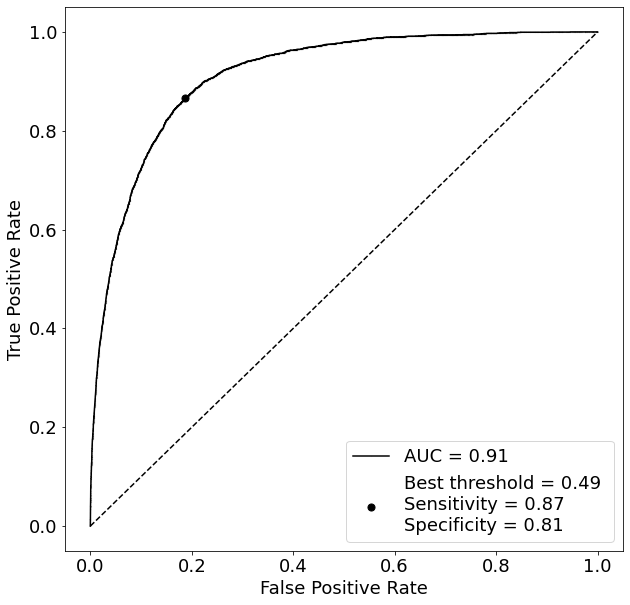

In [21]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_bs['prob']
y_test = X_test_bs['eGFR_ab']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]

print('eGFR60 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 18
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### external

eGFR60 model, knhanes, external validation

Classification Report

Best Threshold=0.463, sensitivity = 0.89, specificity = 0.82, J=0.706
              precision    recall  f1-score   support

      normal       1.00      0.82      0.90 34743760.49391329
    abnormal       0.09      0.89      0.17 726038.3826888512

    accuracy                           0.82 35469798.87660214
   macro avg       0.54      0.85      0.53 35469798.87660214
weighted avg       0.98      0.82      0.88 35469798.87660214



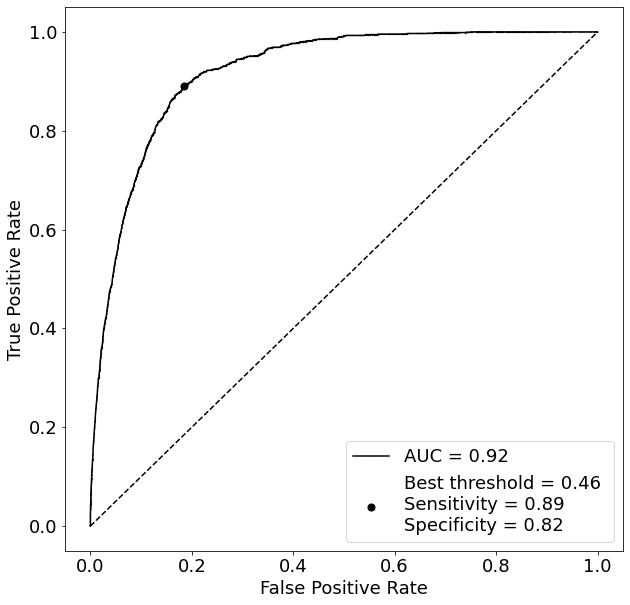

In [22]:
# external validation 

# Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
# calculate roc curves
fpr_ev, tpr_ev, thresholds_ev = roc_curve(y_test_ev, y_prob_ev, sample_weight=ev['wt'])
# get the best threshold
J_ev = tpr_ev - fpr_ev
ix_ev = argmax(J_ev)
best_thresh_ev = thresholds_ev[ix_ev]

print('eGFR60 model, knhanes, external validation')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_ev, tpr_ev[ix_ev], 1-fpr_ev[ix_ev], J_ev[ix_ev]))

y_prob_pred_ev = (y_prob_ev >= best_thresh_ev).astype(bool)
print(classification_report(y_test_ev, y_prob_pred_ev, target_names=['normal', 'abnormal'], sample_weight=ev['wt']))

#plot roc and best threshold
sens_ev, spec_ev = tpr_ev[ix_ev], 1-fpr_ev[ix_ev]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_ev, tpr_ev, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(fpr_ev[ix_ev], tpr_ev[ix_ev], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_ev, sens_ev, spec_ev))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### both internal and external

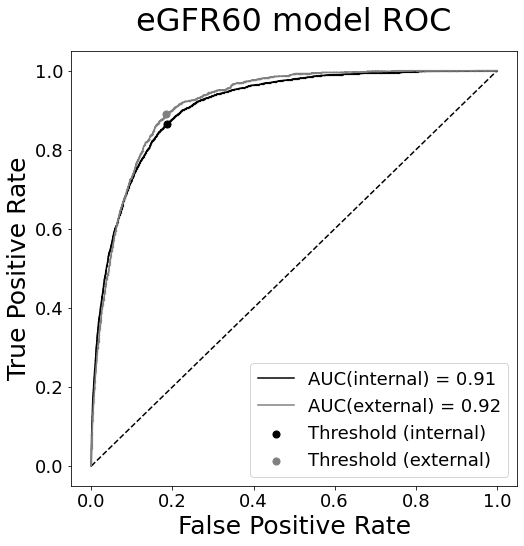

In [23]:
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (8,8)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC(internal) = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(1-spec, sens, marker='o', s=50, color='k'
            , label='Threshold (internal)' 
            #% (best_thresh)
           )

plt.plot(fpr_ev, tpr_ev, marker='.', color='grey', markersize=0.05, label="AUC(external) = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(1-spec_ev, sens_ev, marker='o', s=50, color='grey'
            , label='Threshold (external)' 
            #% (best_thresh_ev)
           )

# axis labels
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.legend(loc=4, fontsize=18)
plt.title('eGFR60 model ROC', size=32, pad=20)
# show the plot
#plt.show()

# save as png
plt.savefig('/home/danssa/proj_ua/images/new_4sub/60model_roc.png', dpi=300)

# SHAP value

In [24]:
#SHAP value 

shap.initjs()
print(shap.__version__)

names = pd.read_csv('~/proj_ua/data/knhanes_urine_explain_10types.csv', index_col='var')
background = shap.maskers.Independent(X_train_features_new, max_samples=100)
explainer = shap.TreeExplainer(model_new, model_output='probability', data=X_train_features_new)
shap_values = explainer.shap_values(X_train_features_new)
meaning_dict = names.to_dict()['name']

0.37.0


100%|===================| 175966/176015 [14:29<00:00]        

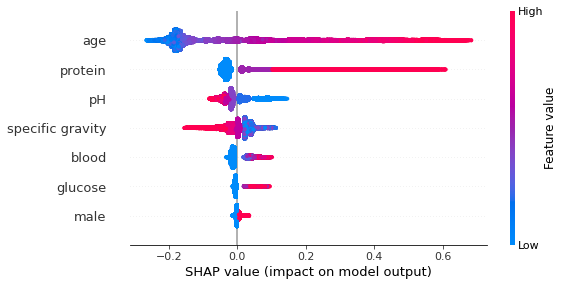

In [25]:
# SHAP, train set
shap.summary_plot(shap_values, X_train_features_new.rename(columns=meaning_dict))

In [26]:
#shap gray version configuration
import matplotlib.colors as colors

gray_val=0.75
cdict = {'red': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)],
        'green': [(0.0, gray_val, gray_val),
                 (1.0, 0.0, 0.0)],
        'blue': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)]}
gray2black = colors.LinearSegmentedColormap(name='red', segmentdata=cdict)

In [27]:
# SHAP,test all
shap_values_all = explainer.shap_values(X_test_features)

100%|===================| 43917/44005 [03:36<00:00]        

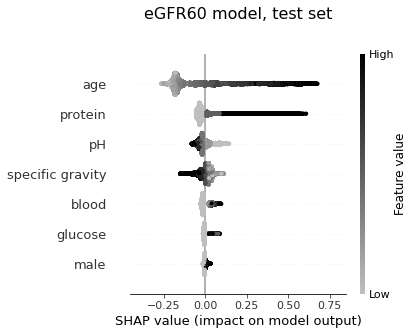

In [28]:
shap.summary_plot(shap_values_all, X_test_features.rename(columns=meaning_dict), show=False, 
                  cmap=plt.get_cmap(gray2black)
                 )
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(6)

plt.xlim([-0.45,0.85])
plt.title('eGFR60 model, test set', fontsize=16, pad=35)
plt.tight_layout()

#save as png
plt.savefig('/home/danssa/proj_ua/images/new_4sub/60model_shap.png', dpi=300)

# sub group analysis, internal : DM, HTN, old age, proteinuria

In [43]:
# subset each group
X_test_g1 = X_test_bs.query('dm==1')
X_test_g2 = X_test_bs.query('htn==1')
X_test_g3 = X_test_bs.query('age>=65')
X_test_g4 = X_test_bs.query('he_upro>1')
X_test_g5 = X_test_bs.query('dm==1&age>=65|htn==1&age>=65|he_upro>1&age>=65')

In [44]:
print('total cases, prevalence (cases)')
print('group1: %d, %.1f (%d)' % (len(X_test_g1), sum(X_test_g1['eGFR_ab'])/len(X_test_g1)*100, sum(X_test_g1['eGFR_ab'])))
print('group2: %d, %.1f (%d)' % (len(X_test_g2), sum(X_test_g2['eGFR_ab'])/len(X_test_g2)*100, sum(X_test_g2['eGFR_ab'])))
print('group3: %d, %.1f (%d)' % (len(X_test_g3), sum(X_test_g3['eGFR_ab'])/len(X_test_g3)*100, sum(X_test_g3['eGFR_ab'])))
print('group4: %d, %.1f (%d)' % (len(X_test_g4), sum(X_test_g4['eGFR_ab'])/len(X_test_g4)*100, sum(X_test_g4['eGFR_ab'])))
print('group5: %d, %.1f (%d)' % (len(X_test_g5), sum(X_test_g5['eGFR_ab'])/len(X_test_g5)*100, sum(X_test_g5['eGFR_ab'])))

total cases, prevalence (cases)
group1: 1085, 4.0 (43)
group2: 1764, 2.2 (38)
group3: 7142, 27.8 (1989)
group4: 3782, 25.8 (976)
group5: 1462, 41.3 (604)


In [50]:
print('train old age & diabetes', 
      sum(X_train.query('age>=65&dm==1')['eGFR_ab'])/len(X_train.query('age>=65&dm==1')),
      sum(X_train.query('age>=65&dm==0')['eGFR_ab'])/len(X_train.query('age>=65&dm==0')))

train old age & diabetes 0.14958158995815898 0.28615698713040943


In [46]:
print('test old age & diabetes',
      sum(X_test_g3.query('dm==1')['eGFR_ab'])/len(X_test_g3.query('dm==1')),
      sum(X_test_g3.query('dm==0')['eGFR_ab'])/len(X_test_g3.query('dm==0')))

test old age & diabetes 0.125 0.2834634287366291


## sub1 : DM

In [31]:
# test set
data = X_test_g1

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s1 = []
th_box_s1 = []
se_box_s1 = []
sp_box_s1 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s1.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s1.append(best_thresh)
    se_box_s1.append(se)
    sp_box_s1.append(sp)

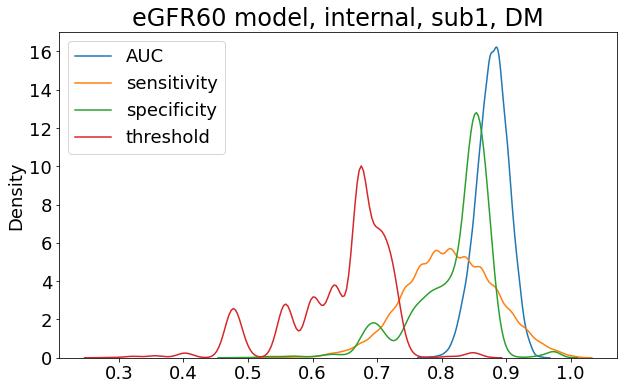

auc mean: 0.88 (0.83-0.92), median:0.88
se  mean: 0.81 (0.67-0.95), median:0.81
sp  mean: 0.82 (0.68-0.88), median:0.84
th  mean: 0.64 (0.48-0.73), median:0.67


In [32]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s1, label='AUC') 
sns.kdeplot(se_box_s1, label='sensitivity')
sns.kdeplot(sp_box_s1, label='specificity')
sns.kdeplot(th_box_s1, label='threshold')
plt.title("eGFR60 model, internal, sub1, DM", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s1, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s1), lower_auc, upper_auc, np.median(auc_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s1, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s1), lower_se, upper_se, np.median(se_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s1, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s1), lower_sp, upper_sp, np.median(sp_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s1, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s1), lower_th, upper_th, np.median(th_box_s1)))

In [33]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1['prob']
y_test = X_test_g1['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group1')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group1
AUC         : 0.88
sensitivity : 0.77
specificity : 0.85
Threshold   : 0.67

Classification Report

              precision    recall  f1-score   support

      normal       0.99      0.85      0.91      1042
    abnormal       0.17      0.77      0.28        43

    accuracy                           0.84      1085
   macro avg       0.58      0.81      0.60      1085
weighted avg       0.96      0.84      0.89      1085



## sub2 : HTN

In [34]:
# test set
data = X_test_g2

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s2 = []
th_box_s2 = []
se_box_s2 = []
sp_box_s2 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s2.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s2.append(best_thresh)
    se_box_s2.append(se)
    sp_box_s2.append(sp)

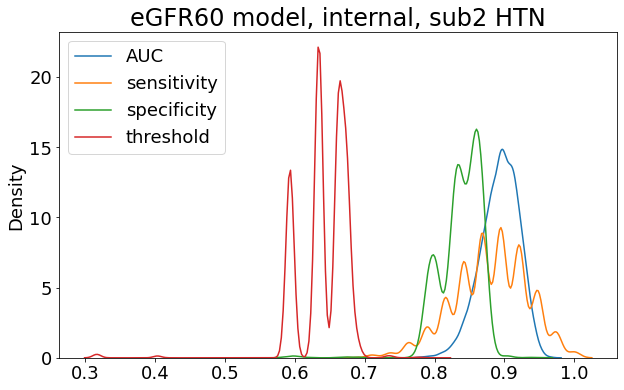

auc mean: 0.89 (0.83-0.94), median:0.90
se  mean: 0.88 (0.76-0.97), median:0.89
sp  mean: 0.84 (0.78-0.88), median:0.84
th  mean: 0.64 (0.59-0.69), median:0.63


In [35]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s2, label='AUC') 
sns.kdeplot(se_box_s2, label='sensitivity')
sns.kdeplot(sp_box_s2, label='specificity')
sns.kdeplot(th_box_s2, label="threshold")
plt.title("eGFR60 model, internal, sub2 HTN", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s2, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s2), lower_auc, upper_auc, np.median(auc_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s2, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s2), lower_se, upper_se, np.median(se_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s2, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s2), lower_sp, upper_sp, np.median(sp_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s2, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s2), lower_th, upper_th, np.median(th_box_s2)))

In [36]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2['prob']
y_test = X_test_g2['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group2')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group2
AUC         : 0.89
sensitivity : 0.87
specificity : 0.83
Threshold   : 0.63

Classification Report

              precision    recall  f1-score   support

      normal       1.00      0.83      0.91      1726
    abnormal       0.10      0.87      0.18        38

    accuracy                           0.83      1764
   macro avg       0.55      0.85      0.54      1764
weighted avg       0.98      0.83      0.89      1764



## sub3 : old age, age>=65

In [37]:
# test set
data = X_test_g3

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s3 = []
th_box_s3 = []
se_box_s3 = []
sp_box_s3 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s3.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s3.append(best_thresh)
    se_box_s3.append(se)
    sp_box_s3.append(sp)

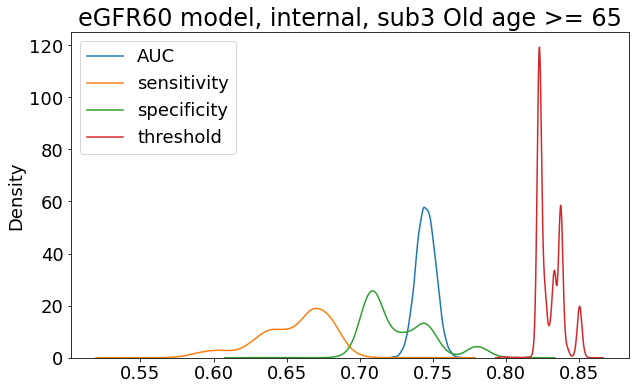

auc mean: 0.75 (0.73-0.76), median:0.75
se  mean: 0.66 (0.59-0.69), median:0.66
sp  mean: 0.73 (0.70-0.78), median:0.72
th  mean: 0.83 (0.82-0.85), median:0.83


In [38]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s3, label='AUC') 
sns.kdeplot(se_box_s3, label='sensitivity')
sns.kdeplot(sp_box_s3, label='specificity')
sns.kdeplot(th_box_s3, label='threshold')
plt.title("eGFR60 model, internal, sub3 Old age >= 65", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s3, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s3), lower_auc, upper_auc, np.median(auc_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s3, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s3), lower_se, upper_se, np.median(se_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s3, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s3), lower_sp, upper_sp, np.median(sp_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s3, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s3), lower_th, upper_th, np.median(th_box_s3)))

In [39]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g3['prob']
y_test = X_test_g3['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group3')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group3
AUC         : 0.75
sensitivity : 0.67
specificity : 0.71
Threshold   : 0.82

Classification Report

              precision    recall  f1-score   support

      normal       0.85      0.71      0.77      5153
    abnormal       0.47      0.67      0.55      1989

    accuracy                           0.70      7142
   macro avg       0.66      0.69      0.66      7142
weighted avg       0.74      0.70      0.71      7142



## sub4 : proteinuria

In [40]:
# test set
data = X_test_g4

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

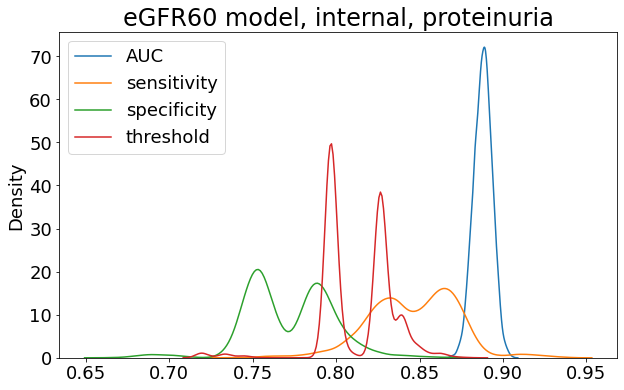

auc mean: 0.89 (0.88-0.90), median:0.89
se  mean: 0.85 (0.79-0.89), median:0.85
sp  mean: 0.77 (0.73-0.82), median:0.77
th  mean: 0.81 (0.79-0.85), median:0.81


In [41]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR60 model, internal, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [42]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g4['prob']
y_test = X_test_g4['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group4')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group4
AUC         : 0.89
sensitivity : 0.86
specificity : 0.75
Threshold   : 0.80

Classification Report

              precision    recall  f1-score   support

      normal       0.94      0.75      0.84      2806
    abnormal       0.55      0.86      0.67       976

    accuracy                           0.78      3782
   macro avg       0.74      0.81      0.75      3782
weighted avg       0.84      0.78      0.79      3782



## sub5 : age>=65 and (dm or htn or proteinuria)

In [47]:
# test set
data = X_test_g5

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

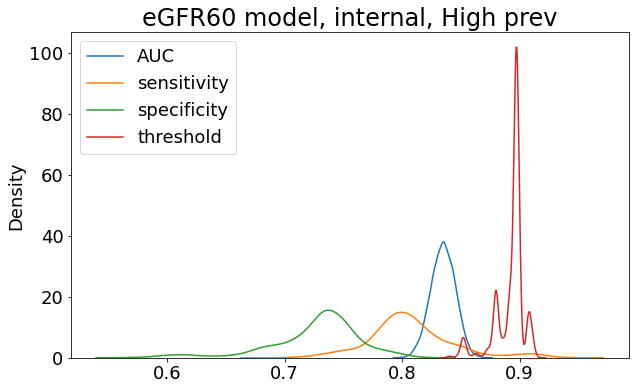

auc mean: 0.83 (0.81-0.85), median:0.83
se  mean: 0.81 (0.74-0.91), median:0.80
sp  mean: 0.73 (0.61-0.79), median:0.73
th  mean: 0.89 (0.85-0.91), median:0.90


In [48]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR60 model, internal, High prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [49]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g5['prob']
y_test = X_test_g5['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group5')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group5
AUC         : 0.84
sensitivity : 0.79
specificity : 0.74
Threshold   : 0.90

Classification Report

              precision    recall  f1-score   support

      normal       0.83      0.74      0.78       858
    abnormal       0.68      0.79      0.73       604

    accuracy                           0.76      1462
   macro avg       0.76      0.76      0.76      1462
weighted avg       0.77      0.76      0.76      1462

